In [1]:
import sys as _sys
import pickle as _pkl
import warnings as _wrn
import itertools as _itr

import numpy as _nmp
import numpy.random as _rnd
import matplotlib.pyplot as _plt
import pandas as _pnd

%load_ext autoreload
%autoreload 2
%matplotlib inline

_wrn.filterwarnings('always')
_plt.style.use('ggplot')

In [3]:
import eQTLseq as _assoc

Fitting gene 12612 of 12613
540 genes did not converge
/Users/dimitris/Venvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:92: DeprecationWarning: DisplayFormatter._ipython_display_formatter_default is deprecated: use @default decorator instead.
  def _ipython_display_formatter_default(self):
/Users/dimitris/Venvs/py35/lib/python3.5/site-packages/IPython/core/formatters.py:669: DeprecationWarning: PlainTextFormatter._singleton_printers_default is deprecated: use @default decorator instead.
  def _singleton_printers_default(self):


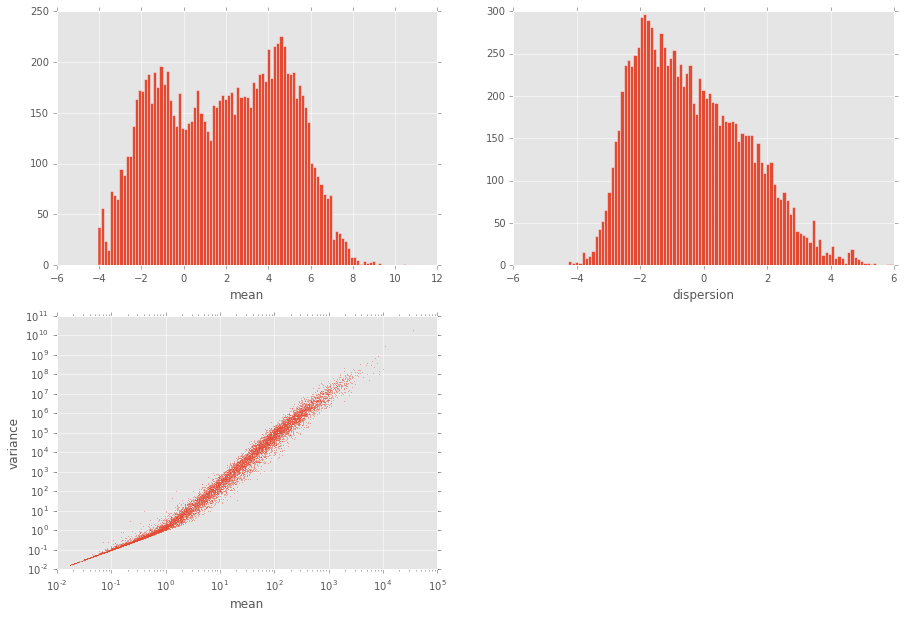

In [4]:
def fcn(fname):
    counts = _pnd.read_table(fname, index_col=0).values
    counts = counts[counts.sum(1)>0, :]  # remove zero-sum rows
    fit = _assoc.fit_nbinom_model(counts)
    print('{} genes did not converge'.format((~fit['converged']).sum()), file=_sys.stderr)
    idxs = (fit['converged']) & (_nmp.log(fit['phi']) > -10)
    pars = {'mu': fit['mu'][idxs], 'phi': fit['phi'][idxs]}

    _plt.figure(figsize=(15,10))
    _plt.subplot(2,2,1); _plt.hist(_nmp.log(pars['mu']), 100); _plt.xlabel('mean')
    _plt.subplot(2,2,2); _plt.hist(_nmp.log(pars['phi']), 100); _plt.xlabel('dispersion');
    _plt.subplot(2,2,3); _plt.loglog(pars['mu'], pars['mu'] + pars['mu']**2 / pars['phi'], '.', markersize=0.5); _plt.xlabel('mean'); _plt.ylabel('variance');    

    return pars

##
pars = fcn('data/montpick_count_table_CEU.txt')

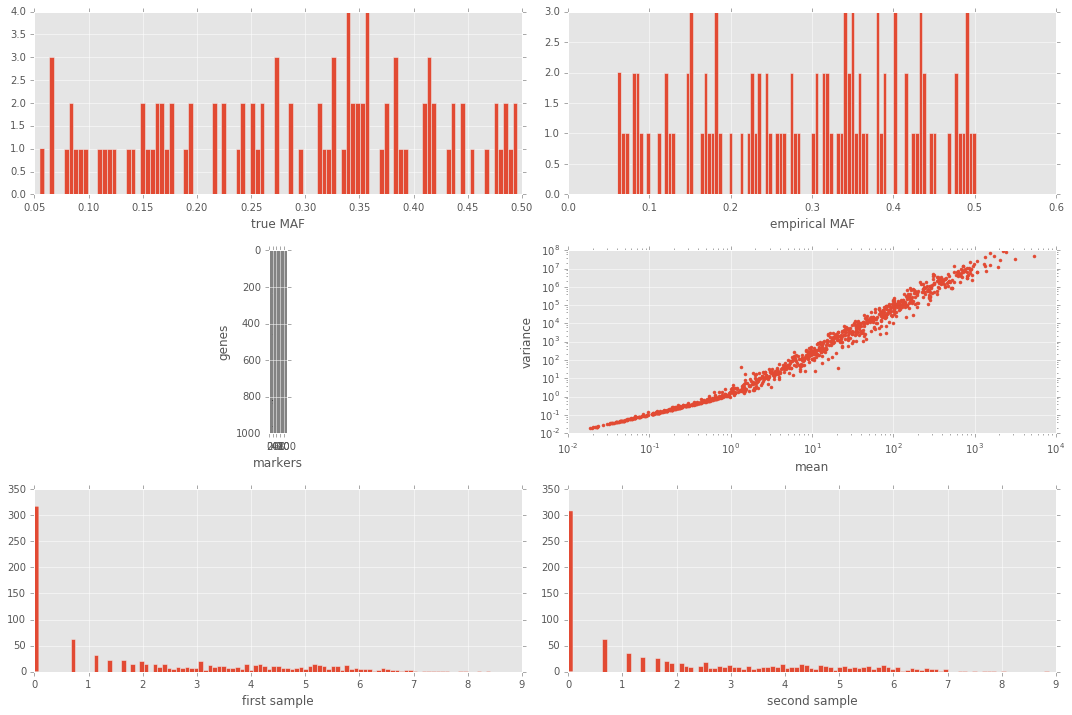

In [27]:
def fcn(n_samples=1000, n_markers=100, n_markers_causal=2, n_genes=1000, n_genes_affected=10, MAF_range=[0.05, 0.5]):
    data_geno = _assoc.simulate_genotypes(n_samples, n_markers, MAF_range)
    data_pheno = _assoc.simulate_eQTLs(data_geno['G'], pars['mu'], pars['phi'], 
                                       n_markers_causal=n_markers_causal, 
                                       n_genes=n_genes, n_genes_affected=n_genes_affected, s2=1)

    _plt.figure(figsize = (15,10));
    _plt.subplot(3,2,1); _plt.hist(data_geno['MAF'], 100); _plt.xlabel('true MAF')
    _plt.subplot(3,2,2); _plt.hist(data_geno['G'].sum(0) / (2 * n_samples), 100); _plt.xlabel('empirical MAF')
    _plt.subplot(3,2,3); _plt.imshow(data_pheno['beta'], cmap=_plt.cm.gray); _plt.xlabel('markers'); _plt.ylabel('genes')
    _plt.subplot(3,2,4); _plt.loglog(data_pheno['mu'], data_pheno['mu'] + data_pheno['mu']**2 / data_pheno['phi'], '.'); _plt.xlabel('mean'); _plt.ylabel('variance');
    _plt.subplot(3,2,5); _plt.hist(_nmp.log(data_pheno['Z'][:,0]+1), 100); _plt.xlabel('first sample');
    _plt.subplot(3,2,6); _plt.hist(_nmp.log(data_pheno['Z'][:,1]+1), 100); _plt.xlabel('second sample');
    _plt.tight_layout()
    
    return {**data_geno, **data_pheno}

##
data = fcn()

In [36]:
Z = data['Z'] / _assoc.calculate_norm_factors(data['Z'])
# Z = _assoc.transform_data(Z, kind='log')
res = _assoc.run(Z, data['G'], n_iters = 1000, mdl='NBinomial4', scale=False, n_threads=1)    

Starting...
Iteration 1000 of 1000
Done!


[0.0341256534859605,
 0.49780129811310214,
 0.59999999999999998,
 0.0,
 12,
 0,
 99980,
 8]

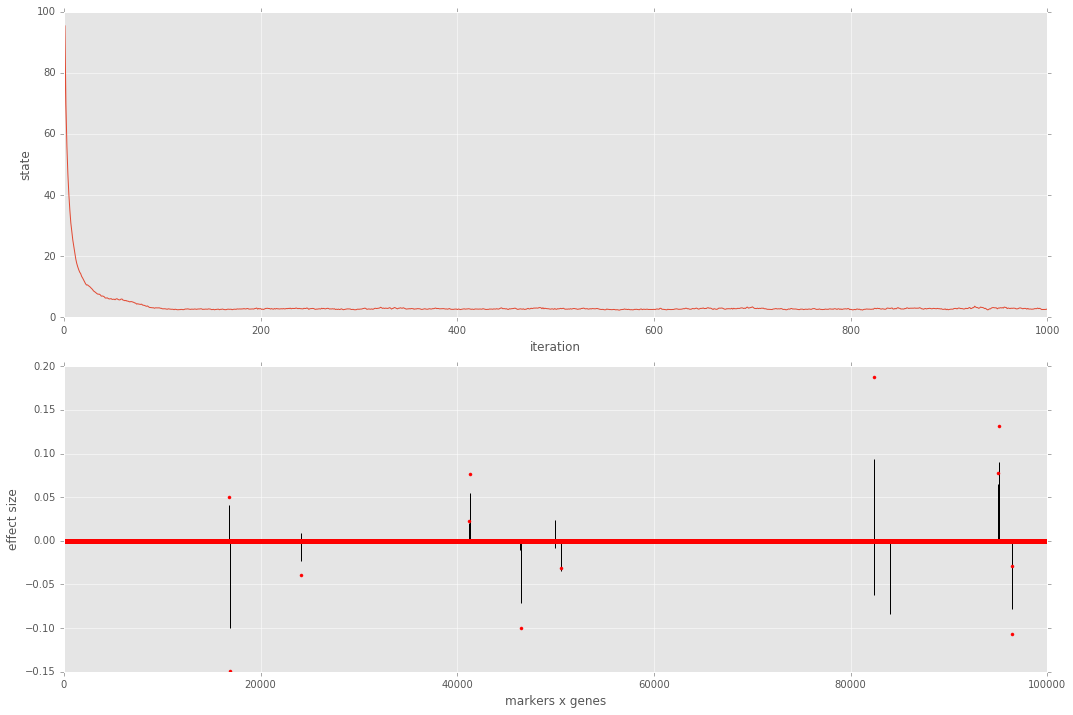

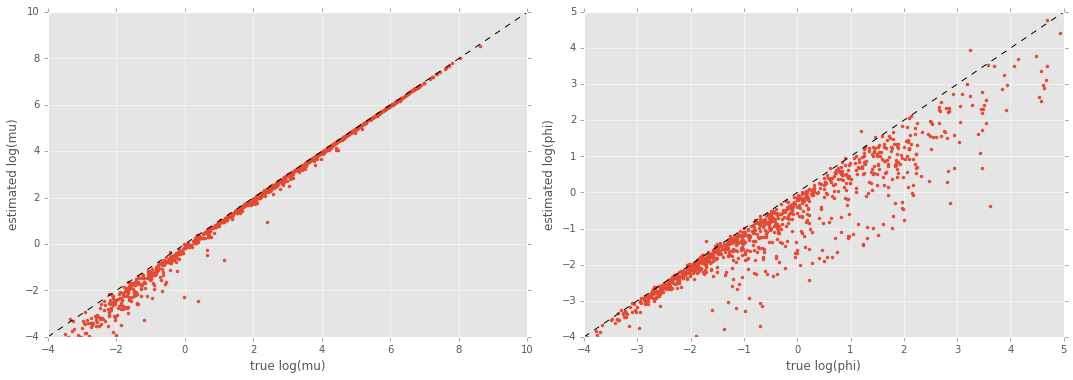

In [37]:
def fcn():
    _plt.figure(figsize = (15,10));
    _plt.subplot(2,1,1); _plt.plot(res['state']); _plt.xlabel('iteration'); _plt.ylabel('state')

    beta_estim = res['beta'] / _nmp.abs(res['beta']).sum()
    beta_true = data['beta'] / _nmp.abs(data['beta']).sum()
    n_genes, n_markers = beta_true.shape

    _plt.subplot(2,1,2); 
    _plt.vlines(range(n_markers * n_genes), 0, beta_true.ravel()); 
    _plt.axhline(linestyle='--', color='k');
    _plt.plot(beta_estim.ravel(), 'r.'); _plt.xlabel('markers x genes'); _plt.ylabel('effect size')

    _plt.tight_layout()

    if 'mu' in res:
        _plt.figure(figsize = (15,10))
        _plt.subplot(2,2,1)
        _plt.plot(_nmp.log(data['mu']), _nmp.log(res['mu']), '.'); _plt.ylim(_plt.xlim()); 
        _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
        _plt.xlabel('true log(mu)'); _plt.ylabel('estimated log(mu)')

        if 'phi' in res:
            _plt.subplot(2,2,2)
            _plt.plot(_nmp.log(data['phi']), _nmp.log(res['phi']), '.'); _plt.ylim(_plt.xlim()); 
            _plt.plot(_plt.gca().get_xlim(),_plt.gca().get_ylim(), '--k'); 
            _plt.xlabel('true log(phi)'); _plt.ylabel('estimated log(phi)')

    _plt.tight_layout()

    return _assoc.calculate_metrics(res['beta'], data['beta'])

##
metrics = fcn()
[metrics[_] for _ in ['RSS', 'TPR', 'FDR', 'TP', 'FP', 'TN', 'FN']]

In [34]:
def fcn():
    N_MARKERS = 100
    N_GENES = 100
    S2=1

    N_SAMPLES = [1000, 500, 250, 125, 65]
    N_GENES_AFFECTED = [1, 5, 10]
    N_MARKERS_CAUSAL = [1, 5, 10]
    REP = [1,2,3]
                    
    combs = _itr.product(N_SAMPLES, N_GENES_AFFECTED, N_MARKERS_CAUSAL, REP)
    
    for item in combs:
        n_samples, n_genes_affected, n_markers_causal, rep = item
        fname = 'data/N{}.G{}_{}.M{}_{}.V{}.r{}.pkl'.format(n_samples, 
                                                            N_GENES, n_genes_affected, 
                                                            N_MARKERS, n_markers_causal, 
                                                            S2, rep)
        print('Generating {}'.format(fname), file=_sys.stderr)
        data_geno = _assoc.simulate_genotypes(n_samples, N_MARKERS)
        data_pheno = _assoc.simulate_eQTLs(data_geno['G'], pars['mu'], pars['phi'], 
                                           n_markers_causal=n_markers_causal, 
                                           n_genes=N_GENES, n_genes_affected=n_genes_affected, s2=S2)
        with open(fname, 'wb') as fh:
            _pkl.dump({**data_geno, **data_pheno}, fh)

##
fcn()

Generating data/N1000.G100_1.M100_1.V1.r1.pkl
Generating data/N1000.G100_1.M100_1.V1.r2.pkl
Generating data/N1000.G100_1.M100_1.V1.r3.pkl
Generating data/N1000.G100_1.M100_5.V1.r1.pkl
Generating data/N1000.G100_1.M100_5.V1.r2.pkl
Generating data/N1000.G100_1.M100_5.V1.r3.pkl
Generating data/N1000.G100_1.M100_10.V1.r1.pkl
Generating data/N1000.G100_1.M100_10.V1.r2.pkl
Generating data/N1000.G100_1.M100_10.V1.r3.pkl
Generating data/N1000.G100_5.M100_1.V1.r1.pkl
Generating data/N1000.G100_5.M100_1.V1.r2.pkl
Generating data/N1000.G100_5.M100_1.V1.r3.pkl
Generating data/N1000.G100_5.M100_5.V1.r1.pkl
Generating data/N1000.G100_5.M100_5.V1.r2.pkl
Generating data/N1000.G100_5.M100_5.V1.r3.pkl
Generating data/N1000.G100_5.M100_10.V1.r1.pkl
Generating data/N1000.G100_5.M100_10.V1.r2.pkl
Generating data/N1000.G100_5.M100_10.V1.r3.pkl
Generating data/N1000.G100_10.M100_1.V1.r1.pkl
Generating data/N1000.G100_10.M100_1.V1.r2.pkl
Generating data/N1000.G100_10.M100_1.V1.r3.pkl
Generating data/N1000.G10

In [46]:
def fcn():
    N_MARKERS = 100
    N_GENES = 100
    S2=1

    N_SAMPLES = [1000, 500, 250, 125, 65]
    N_GENES_AFFECTED = [1, 5, 10]
    N_MARKERS_CAUSAL = [1, 5, 10]
    REP = [1,2,3]

    combs1 = _itr.product(N_SAMPLES, N_GENES_AFFECTED, N_MARKERS_CAUSAL, REP, 
                          ['Normal'], ['log', 'boxcox', 'blom'])
    combs2 = _itr.product(N_SAMPLES, N_GENES_AFFECTED, N_MARKERS_CAUSAL, REP, 
                          ['NBinomial', 'NBinomial2', 'NBinomial3', 'NBinomial4','Poisson', 'Binomial'], ['none'])
    
    rows = []
    for item in list(combs1) + list(combs2):
        n_samples, n_genes_affected, n_markers_causal, rep, mdl, trans = item        
        pre = 'N{}.G{}_{}.M{}_{}.V{}.r{}'.format(n_samples, 
                                                 N_GENES, n_genes_affected, 
                                                 N_MARKERS, n_markers_causal, 
                                                 S2, rep)
        
        print('Processing {}'.format('.'.join((pre, mdl, trans, 'pkl'))), file=_sys.stderr)
        
        with open('/Users/dimitris/Dropbox/eQTLseq/data/' + '.'.join((pre,'pkl')), 'rb') as fh:
            data = _pkl.load(fh)

        with open('/Users/dimitris/Dropbox/eQTLseq/results/' + '.'.join((pre, mdl, trans, 'pkl')), 'rb') as fh:
            res = _pkl.load(fh)

        metrics = _assoc.calculate_metrics(res['beta'], data['beta'])
        rows.append({
                'NSAMPLES': n_samples, 
                'NGENES': N_GENES,
                'NMARKERS': N_MARKERS,
                'NGENES_AFFECTED': n_genes_affected,
                'NMARKERS_CAUSAL': n_markers_causal,
                'REP': rep,
                'S2': S2,
                'MODEL': mdl, 
                'TRANS': trans, 
                **metrics
        })
        
    
    return _pnd.DataFrame(rows)
    
##
metrics = fcn()

Processing N1000.G100_1.M100_1.V1.r1.Normal.log.pkl
Processing N1000.G100_1.M100_1.V1.r1.Normal.boxcox.pkl
Processing N1000.G100_1.M100_1.V1.r1.Normal.blom.pkl
Processing N1000.G100_1.M100_1.V1.r2.Normal.log.pkl
Processing N1000.G100_1.M100_1.V1.r2.Normal.boxcox.pkl
Processing N1000.G100_1.M100_1.V1.r2.Normal.blom.pkl
Processing N1000.G100_1.M100_1.V1.r3.Normal.log.pkl
Processing N1000.G100_1.M100_1.V1.r3.Normal.boxcox.pkl
Processing N1000.G100_1.M100_1.V1.r3.Normal.blom.pkl
Processing N1000.G100_1.M100_5.V1.r1.Normal.log.pkl
Processing N1000.G100_1.M100_5.V1.r1.Normal.boxcox.pkl
Processing N1000.G100_1.M100_5.V1.r1.Normal.blom.pkl
Processing N1000.G100_1.M100_5.V1.r2.Normal.log.pkl
Processing N1000.G100_1.M100_5.V1.r2.Normal.boxcox.pkl
Processing N1000.G100_1.M100_5.V1.r2.Normal.blom.pkl
Processing N1000.G100_1.M100_5.V1.r3.Normal.log.pkl
Processing N1000.G100_1.M100_5.V1.r3.Normal.boxcox.pkl
Processing N1000.G100_1.M100_5.V1.r3.Normal.blom.pkl
Processing N1000.G100_5.M100_1.V1.r1.Nor

FileNotFoundError: [Errno 2] No such file or directory: '/Users/dimitris/Dropbox/eQTLseq/results/N1000.G100_5.M100_5.V1.r1.NBinomial.none.pkl'

In [39]:
metrics.to_csv('./metrics.txt', index=False)

In [ ]:
[0.011701691369723238,
 0.83156014469605621,
 0.69999999999999996,
 0.0,
 14,
 0,
 4980,
 6]